In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 21.2MB/s 
     |████████████████████████████████| 901kB 42.4MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import spatial
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from transformers import (
    BertModel, BertConfig, BertTokenizer, TrainingArguments, 
    Trainer, LineByLineTextDataset, DataCollatorForLanguageModeling,
    DataCollatorWithPadding, DataCollator, BertForMaskedLM, BertForPreTraining
)

# Достаём эмбеддинги из предобученного BERT

## Загружаем модель

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
model = BertModel.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-12_H-128_A-2')
config = BertConfig.from_pretrained('google/bert_uncased_L-12_H-128_A-2', output_hidden_states=True)
model = BertModel.from_pretrained('google/bert_uncased_L-12_H-128_A-2', config=config)

Some weights of the model checkpoint at google/bert_uncased_L-12_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Функции для эмбеддингов

In [ ]:
text = 'perfect weather'
def get_ids_tokens(text, tokenizer=tokenizer):
    tokens = tokenizer.tokenize('[CLS] ' + text + ' [SEP]')
    ids = tokenizer.encode(text)
    return ids, tokens

get_ids_tokens(text)

([101, 3819, 4633, 102], ['[CLS]', 'perfect', 'weather', '[SEP]'])

In [ ]:
def get_embeddings_from_last(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте как крайние hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    word_embeddings = model(**encoded_input)[2][-1][0].detach().numpy()[1:-1]
    return word_embeddings

get_embeddings_from_last('hello there guys').shape

(3, 128)

In [ ]:
k, q, m, w = get_embeddings_from_last("king queen man woman")
spatial.distance.cosine(k - m + w, q)

0.1589096188545227

In [ ]:
def get_embeddings(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте на основе 4 крайних hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    four_last_hidden = model(**encoded_input)[2][-4:]
    four_last_hidden = np.asarray([hidden[0].detach().numpy() for hidden in four_last_hidden])
    word_embeddings = four_last_hidden[:, 1:-1].sum(axis=0)
    return word_embeddings

# get_embeddings("king queen man woman")

In [ ]:
|k, q, m, w = get_embeddings("king queen man woman")
spatial.distance.cosine(k - m + w, q)

SyntaxError: ignored

Как предлагается в статье, в качестве эмбеддинга будем брать четыре hidden state'а вместо одного последнего.

## Сохраняем эмбеддинги для всех слов в словаре

In [ ]:
all_embeddings = []  # list of all embeddings in vocabulary

for word in tqdm(tokenizer.ids_to_tokens.values()):
    all_embeddings.append(get_embeddings(word)[0])

In [ ]:
# np.save('bert-base-uncased-embeddings.npy', np.asarray(all_embeddings))
# np.save('drive/MyDrive/Coursework2021/bert_base_uncased_vocab_embeddings.npy', np.asarray(all_embeddings))

np.save('bert-base-uncased-embeddings.npy', np.asarray(all_embeddings))
np.save('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings.npy', np.asarray(all_embeddings))

In [ ]:
# with open('bert_base_uncased_tokens.txt', 'w') as f:
#     for token in tokenizer.ids_to_tokens.values():
#         print(token, file=f)
# with open('drive/MyDrive/Coursework2021/bert_base_uncased_vocab.txt', 'w') as f:
#     for token in tokenizer.ids_to_tokens.values():
#         print(token, file=f)

with open('bert_base_uncased_tokens.txt', 'w') as f:
    for token in tokenizer.ids_to_tokens.values():
        print(token, file=f)
with open('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab.txt', 'w') as f:
    for token in tokenizer.ids_to_tokens.values():
        print(token, file=f)

In [ ]:
embeddings = np.load('bert-base-uncased-embeddings.npy')
assert (all_embeddings == embeddings).mean() == 1

# Строим автоенкодер

TODO: сэмплировать обучающую выборку по частотности.

In [ ]:
all_embeddings = np.load('drive/MyDrive/Coursework2021/bert-base-uncased-embeddings.npy')
with open('drive/MyDrive/Coursework2021/bert-base-uncased-tokens.txt', 'r') as f:
    all_tokens = f.read().split('\n')

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense
from keras.models import Model, Sequential

ORIGINAL_DIM = 768
TARGET_DIM = 30

encoder = Sequential([
    Input(shape=(ORIGINAL_DIM,)),
    Dense(90, activation='tanh'),
    # Dense(32, activation='relu'),
    Dense(TARGET_DIM, activation='tanh')
])

decoder = Sequential([
    Input(shape=(TARGET_DIM,)),
    # Dense(32, activation='relu'),
    Dense(90, activation='tanh'),
    Dense(ORIGINAL_DIM, activation=None)
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
autoencoder.count_params()

144618

In [ ]:
model_history = autoencoder.fit(all_embeddings, all_embeddings, epochs=50, batch_size=64, verbose=False)
# model_history = autoencoder.fit(get_embeddings('king queen man woman'), get_embeddings('king queen man woman'), epochs=1000, batch_size=32, verbose=False)

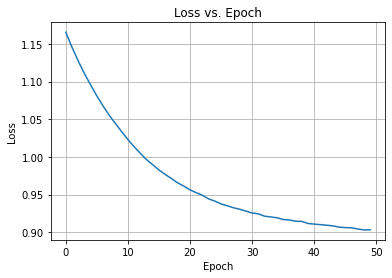

In [ ]:
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [ ]:
reduced_embeddings = encoder(all_embeddings)

def reduce_embedding(word, autoencoder=autoencoder):
    return encoder(get_embeddings(word)).numpy()[0]
    # return encoder(all_embeddings[all_tokens.index(word)].reshape(1, 768)).numpy()[0]

spatial.distance.cosine(reduce_embedding('king') - reduce_embedding('man') + reduce_embedding('woman'), reduce_embedding('queen'))

0.10244959592819214

Должно быть 0.

In [ ]:
spatial.distance.cosine(reduce_embedding('king') - reduce_embedding('man') + reduce_embedding('raining'), reduce_embedding('queen'))

0.15001028776168823

Должно быть 1.

In [ ]:
reduced_embeddings.numpy().mean(axis=0)

array([-0.01662267,  0.9999345 , -0.55297816, -0.02291703,  0.16634402,
       -0.924784  , -0.11784021, -0.11145473,  0.17365946, -0.99895155,
       -1.        , -1.        ,  0.9348011 ,  0.6295178 , -0.01060687,
        0.19058064, -0.06295379,  0.09374467,  0.12911892,  0.9348011 ,
        0.7446825 ,  0.30369976, -0.12631159, -0.9999345 ,  0.08297139,
        0.79676825, -0.13369876, -0.09985589,  0.6179805 ,  0.3636957 ],
      dtype=float32)

Треть элементов в векторах даже не сдвинулись с нуля.

In [ ]:
# Checking property of king - man + woman = queen

property_check = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs = get_embeddings(f'i can see a {word} over there')
    property_check[word] = embs[4]

_a = lambda x: property_check[x]

spatial.distance.cosine(_a('king') - _a('man') + _a('woman'), _a('queen'))

0.09832602739334106

# Проверяю воспроизводимость BERT

Верно ли вообще, что king - man + woman = queen?

In [ ]:
a = get_embeddings_from_last('king')
b = get_embeddings_from_last('queen')
np.mean((a - b) ** 2, axis=1)
spatial.distance.cosine(a[-1], b[-1])

0.13561415672302246

In [ ]:
embs = []
for word in ['boy', 'beauty', 'guy', 'woman']:
    embs.append(get_embeddings_from_last(f'the {word} passed a law'))

print('boy vs guy in same context:', cosine(embs[2][1], embs[0][1]))
print('boy vs beauty in same context:', cosine(embs[0][1], embs[1][1]))

boy vs guy in same context: 0.3710305690765381
boy vs beauty in same context: 0.3971129059791565


In [ ]:
embs = []

print('boy vs guy in no context:', cosine(get_embeddings_from_last('guy'), get_embeddings_from_last('boy')))
print('boy vs beauty in no context:', cosine(get_embeddings_from_last('beauty'), get_embeddings_from_last('boy')))

boy vs guy in no context: 0.19427704811096191
boy vs beauty in no context: 0.37730830907821655


In [ ]:
embs = []
for word in ['boy', 'beauty', 'guy', 'woman']:
    embs.append(get_embeddings_from_last(f'i ate the {word}'))

print('boy vs guy in same context:', cosine(embs[2][3], embs[0][3]))
print('boy vs beauty in same context:', cosine(embs[0][3], embs[1][3]))

boy vs guy in same context: 0.24570775032043457
boy vs beauty in same context: 0.3332405686378479


In [ ]:
def cosine(u, v):
    return spatial.distance.cosine(u, v), np.mean((u - v) ** 2) ** 0.5

embs = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs[word] = []
    embs[word].append(get_embeddings(f'{word}'))
    embs[word].append(get_embeddings(f'{word} is the best'))
    embs[word].append(get_embeddings(f'we know the {word}'))
    embs[word].append(get_embeddings(f'{word} {word}'))

print('VARIOUS DISTANCES BETWEEN KING AND QUEEN:')
print(cosine(embs['king'][0][0], embs['queen'][0][0]))
print(cosine(embs['king'][1][0], embs['queen'][1][0]))
print(cosine(embs['king'][2][-1], embs['queen'][2][-1]))
print(cosine(embs['king'][3][0], embs['queen'][3][0]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):')
print(cosine(embs['king'][0][0] - embs['man'][0][0] + embs['woman'][0][0], embs['queen'][0][0]))
print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):')
print(cosine(embs['king'][0][0] - embs['man'][1][0] + embs['woman'][2][-1], embs['queen'][3][0]))
# print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
# print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
# print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)')
for word in ['king', 'queen', 'man', 'woman']:
    print(cosine(embs[word][0][0], embs[word][1][0]))
    print(cosine(embs[word][1][0], embs[word][2][-1]))
    print(cosine(embs[word][2][-1], embs[word][3][0]))
    print(cosine(embs[word][3][0], embs[word][3][1]))
    print(cosine(embs[word][3][0], embs[word][0][0]))
    print()

VARIOUS DISTANCES BETWEEN KING AND QUEEN:
(0.11764466762542725, 1.105831019483693)
(0.16463828086853027, 1.3402670589187504)
(0.11030858755111694, 1.0856982180205963)
(0.1686956286430359, 1.4168673354498114)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):
(0.2166770100593567, 1.5660456292238996)
(0.16117733716964722, 1.348344091051062)
(0.11721783876419067, 1.1732443882994747)
(0.2791459560394287, 2.060554627318059)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):
(0.6227806210517883, 3.3543426435916883)

NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)
(0.4145054221153259, 2.08452658495257)
(0.37392497062683105, 1.9949899745870912)
(0.34623342752456665, 1.9753107019677871)
(0.2657058835029602, 1.7919402985505226)
(0.26635509729385376, 1.7236887633668536)

(0.4855496883392334, 2.291434455435265)
(0.44787508249282837, 2.213693579154562)
(0.4431809186935425, 2.2443184645183987)
(0.3137674331665039, 1.9529077027559183)
(0.31835770606994

In [ ]:
print('WORD GREEN IN DIFFERENT CONTEXTS')
print(cosine(get_embeddings_from_last('green sofa')[0], get_embeddings_from_last('green chair')[0]))
print(cosine(get_embeddings_from_last('green sofa')[0], get_embeddings_from_last('green box')[0]))
print(cosine(get_embeddings_from_last('green box')[0], get_embeddings_from_last('light green')[1]))

WORD GREEN IN DIFFERENT CONTEXTS
0.12123119831085205
0.44215917587280273
0.6706148087978363


In [ ]:
print('WORD GREEN IN DIFFERENT CONTEXTS (sum of four hidden)')
print(cosine(get_embeddings('green sofa')[0], get_embeddings('green chair')[0]))
print(cosine(get_embeddings('green sofa')[0], get_embeddings('green box')[0]))
print(cosine(get_embeddings('green box')[0], get_embeddings('light green')[1]))

WORD GREEN IN DIFFERENT CONTEXTS (sum of four hidden)
0.098857581615448
0.3535335659980774
0.48835980892181396


In [ ]:
def cosine(u, v):
    return spatial.distance.cosine(u, v), np.mean((u - v) ** 2) ** 0.5

embs = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs[word] = []
    embs[word].append(encoder(get_embeddings(f'{word}')).numpy()[0])
    embs[word].append(encoder(get_embeddings(f'{word} is the best')).numpy()[0])
    embs[word].append(encoder(get_embeddings(f'we know the {word}')).numpy()[-1])
    embs[word].append(encoder(get_embeddings(f'{word} {word}')).numpy()[0])

print('VARIOUS DISTANCES BETWEEN KING AND QUEEN:')
print(cosine(embs['king'][0], embs['queen'][0]))
print(cosine(embs['king'][1], embs['queen'][1]))
print(cosine(embs['king'][2], embs['queen'][2]))
print(cosine(embs['king'][3], embs['queen'][3]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):')
print(cosine(embs['king'][0] - embs['man'][0] + embs['woman'][0], embs['queen'][0]))
print(cosine(embs['king'][1] - embs['man'][1] + embs['woman'][1], embs['queen'][1]))
print(cosine(embs['king'][2] - embs['man'][2] + embs['woman'][2], embs['queen'][2]))
print(cosine(embs['king'][3] - embs['man'][3] + embs['woman'][3], embs['queen'][3]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):')
print(cosine(embs['king'][0] - embs['man'][1] + embs['woman'][2], embs['queen'][3]))
# print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
# print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
# print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)')
for word in ['king', 'queen', 'man', 'woman']:
    print(cosine(embs[word][0], embs[word][1]))
    print(cosine(embs[word][1], embs[word][2]))
    print(cosine(embs[word][2], embs[word][3]))
    print(cosine(embs[word][3], embs[word][3]))
    print(cosine(embs[word][3], embs[word][0]))
    print()

VARIOUS DISTANCES BETWEEN KING AND QUEEN:
(0.03471952676773071, 0.5911668249988083)
(0.03196495771408081, 0.44152428728265025)
(0.01817035675048828, 0.36047307475273216)
(0.018519699573516846, 0.4409981250247325)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):
(0.10986948013305664, 1.0321878734545216)
(0.037877440452575684, 0.4812532548670496)
(0.028219759464263916, 0.4522282672054851)
(0.11279302835464478, 1.1085525472778879)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):
(0.40068870782852173, 2.1788129248316785)

NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)
(0.24522197246551514, 1.3906634893341439)
(0.13141494989395142, 0.9260694481737757)
(0.13576346635818481, 1.0890955937746951)
(0.0, 0.0)
(0.17969214916229248, 1.2836428836606082)

(0.27415257692337036, 1.5540259405791526)
(0.19970154762268066, 1.1639237289150726)
(0.22871029376983643, 1.4550715708745008)
(0.0, 0.0)
(0.2279752492904663, 1.5284181216206156)

(0.3310208320617

Выводы: значительно зависит от контекста. `king - man + woman = queen` в целом проходит проверку, но не очень хорошо и в разных ситуациях по-разному. Есть проблемы с пониманием, что же такое векторное представление BERT и надо ли его пихать в эту задачу.

In [ ]:
# Далее: 
# 1. Доделать автоенкодер (дообучить, изменить).
# 2. Посмотреть равенства и для PCA, и для автоенкодера.
# 3. Пробежать метриками по уменьшенным эмбеддингам.
# 4. Обучить w2v.

Ещё раз PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(30)
reduced_embeddings_pca = pca.fit_transform(all_embeddings)
reduced_embeddings_pca.shape

(30522, 30)

In [ ]:
cosine(pca.transform(get_embeddings('king')) - pca.transform(get_embeddings('man')) + pca.transform(get_embeddings('woman')),
       pca.transform(get_embeddings('queen')))

(0.5047992467880249, 4.7646149112048075)